# The Bias-Variance Decomposition

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

#### Generate the data

In [2]:
def simulator(f, sample_size, std, l=0, h=1):
    x = np.linspace(l, h, sample_size)
    noise = np.random.normal(scale=std, size=x.shape)
    t = f(x) + noise
    return x.reshape(sample_size, -1), t

def f(x):
    return np.sin(2 * np.pi * x)

# generate data
def genrate_data(N_tr=10, N_ts=100, std=0.3, l=0, h=1):
    x_train, y_train = simulator(f, N_tr, std, l=l, h=h)
    x_test = np.linspace(l, h, N_ts)
    y_test = f(x_test)
    return x_train.reshape(N_tr, -1), y_train, x_test.reshape(N_ts, -1), y_test

#### Regularized OLS

In [3]:
class MLE_MAP:
    def __init__(self, mle_mape='MLE', lamba=0.9):
        self.mle_mape = mle_mape.lower()
        self.lamba = lamba
    
    def _scale_fit(self, X, L=-1, H=1):
        P = X.shape[1]
        self.a = []; self.b = []
        for p in range(P):
            self.a.append(((H * min(X[:, p])) - (L * max(X[:, p])))/(H-L))
            self.b.append((max(X[:, p]) - min(X[:, p]))/(H - L))

    def _scale_transform(self, X):
        X_scaled = (X - self.a)/self.b
        return X_scaled.reshape(X.shape[0], -1)
    
    def _scale_inverse(X):
        return (X * self.b) + selfa
    
    def fit(self, X, y, scale=True):
        self.scale = scale
        self.N, self.P = X.shape
        # add cloumn of ones in X for the bias term
        if self.scale:
            self._scale_fit(X)
            X = self._scale_transform(X)
        X = np.append(X, np.ones((self.N, 1)), axis=1)   
        y = y.reshape(self.N, 1)
        if self.mle_mape=='mle':
            # The Normal Equation W(ML) = (X^T X)^-1 X^T Y
            self.W = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            self.B_inv = np.mean(np.square(X.dot(self.W) - y))

        elif self.mle_mape=='map':
            # The Normal Equation W(ML) = (X^T X + lambda I)^-1 X^T Y
            self.W = np.linalg.inv(self.lamba * np.eye(self.P + 1) + X.T.dot(X)).dot(X.T).dot(y)
            self.B_inv = np.mean(np.square(X.dot(self.W) - y))
            
        else:
            raise('Only MLE and MAP')

    def predict(self, X, std=False):
        
        if self.scale:
            X = self._scale_transform(X)
        
        X = X.reshape(-1, self.P)
        X = np.append(X, np.ones((X.shape[0],1)), axis=1)
        preds = np.dot(X, self.W)
        if std:
            std_ = np.sqrt(self.B_inv) + np.zeros_like(preds)
            return preds, std_
        return preds

#### Basis functions

In [4]:
# generate polynomial basis
def PolynomialFeature(X, degrees):
    X_poly = X.copy()
    for i in range(2, degrees+2):
        X_poly = np.append(X_poly, X**i, axis=1)
    return X_poly

# genrate gaussian basis
def GaussianFeatures(X, mu, s):
    if isinstance(mu, int):
        mu = [mu]    
    X_Gauss = X.copy()
    for m in mu:
        X_Gauss = np.append(X_Gauss, np.exp(-0.5 * np.square(X - m)/s), axis=1)
    return np.array(X_Gauss).reshape(X.shape[0], -1)

def SigmoidalFeatures(X, mu, s):
    if isinstance(mu, int):
        mu = [mu] 
    X_Sig = X.copy()
    for m in mu:
        X_Sig = np.append(X_Sig, (np.tanh((X - m) / s) + 1 ) / 2, axis=1)
    return np.array(X_Sig).reshape(X.shape[0], -1)

#### Plot results

In [5]:
def plot_results(X_tr, y_tr, X_ts, y_ts, pred, ax, title=None, text=None):
    ax.plot(X_ts, pred, 'r', label='Regression line')
    ax.plot(X_ts, y_ts, c="g", label="$\sin(2\pi x)$")
    ax.set_xlabel('$X$', size=15)
    ax.set_ylabel('$Y$', rotation=0, size=15)
    if title:
        ax.set_title(title, fontsize=16)
    if text:
        ax.set_ylim(-1.6, 2)
        ax.text(0, 1.7, text, size=20)
    return ax

#### Model training

In [6]:
def train_model(X_tr, X_ts, y, lamba, test=True):
    model = MLE_MAP(mle_mape='map', lamba=lamba)
    model.fit(X_tr, y)
    return model.predict(X_ts) if test else model.predict(X_tr)

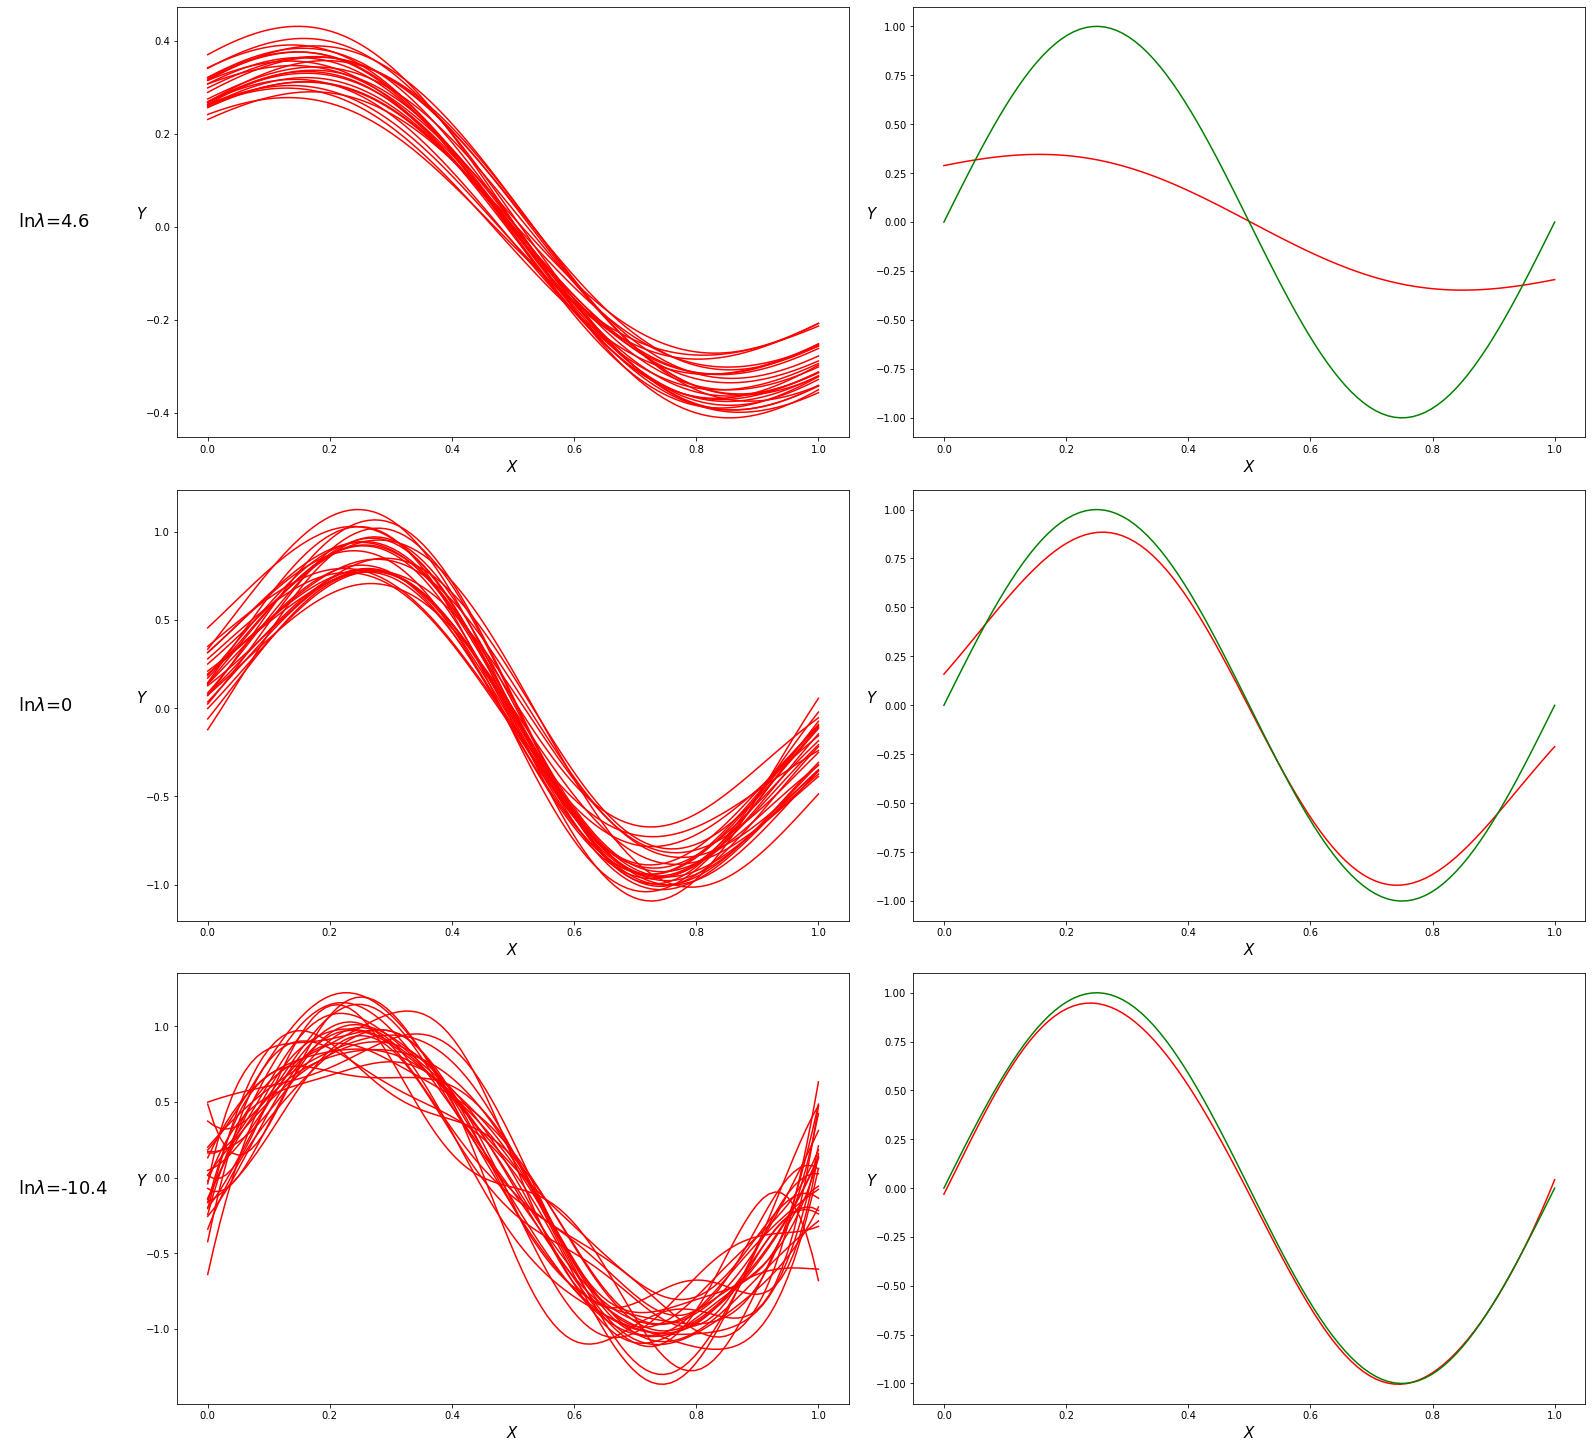

In [28]:
d = 8; s = 0.05
ln_lamda = [4.6, 0, -10.4]
fig = plt.figure(constrained_layout=True, figsize=(22, 20))
widths = [0.5, 3, 3]; heights = [1, 1, 1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)
_, _, X_test, y_test = genrate_data(25)
X_test_ = GaussianFeatures(X_test, np.linspace(0, 1, d), s)
        
for row, l in enumerate(ln_lamda):
    ax0 = fig.add_subplot(spec[row, 0])
    ax0.annotate('ln$\lambda$=%s'%ln_lamda[row], (0.1, 0.5), xycoords='axes fraction', va='center', size=18)
    ax0.axis('off')
    ax1 = fig.add_subplot(spec[row, 1])
    ax1.set_xlabel('$X$', size=15)
    ax1.set_ylabel('$Y$', rotation=0, size=15)
    models_res = []
    for i in range(25):
        # get the data
        X_train, y_train, _, _ = genrate_data(25)
#         X_train_ = PolynomialFeature(X_train, d)
        X_train_ = GaussianFeatures(X_train, np.linspace(0, 1, d), s)
        pred = train_model(X_train_, X_test_, y_train, np.exp(l))
        models_res.append([pred])                
        ax1.plot(X_test, pred, 'r')
    
    ax2 = fig.add_subplot(spec[row, 2])
    ax2.set_xlabel('$X$', size=15)
    ax2.set_ylabel('$Y$', rotation=0, size=15)
    ax2.plot(X_test, np.average(models_res, axis=0)[0], c='r')
    ax2.plot(X_test, y_test, c='g')